In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
base_csv = './data/IMDb/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


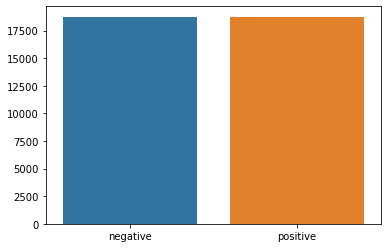

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s
import nltk
nltk.download('stopwords')
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

[nltk_data] Downloading package stopwords to
[nltk_data]     /usagers3/opmos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-6-86a4e789bb87>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [8]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


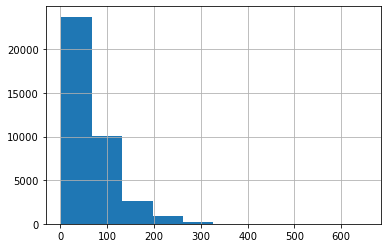

count    37500.000000
mean        69.235120
std         48.089812
min          2.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        652.000000
dtype: float64

In [9]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [10]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [11]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [12]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 100

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [13]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  83,  32, 586],
        [  0,   0,   0,  ...,  26,  13,  45],
        [  0,   0,   0,  ...,  23, 133, 127],
        ...,
        [  0,   0,   0,  ..., 509, 854, 146],
        [  0,   0,   0,  ..., 143,  25,  43],
        [  0,   0,   0,  ...,  66,   3, 243]])
Sample input: 
 tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0])


In [14]:
class LSTMRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        #super(SentimentRNN,self).__init__()
        super().__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [15]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model_name = 'lstm-imdb'
training_round = 2

In [16]:
model = LSTMRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

LSTMRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [17]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [18]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

In [19]:
def train_rnn(model, epochs, optimizer,criterion, train_loader, valid_loader, type_, batch_size=100): 
    clip = 5
    #epochs = 50 
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    best_model_wts = copy.deepcopy(model.state_dict())
    since = time.time()
    
    data_file = open('./data/26-10-2021/Train1/pytorch/lstm/torch_exp_{}_{}_{}.csv'.format(model_name, date, training_round), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Epoch', 'optimizer','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
    best_acc = 0.0
    
    for epoch in range(epochs):
        since_1 = time.time()
        train_losses = []
        train_acc = 0.0
        model.train()
        # initialize hidden state 
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:
        
            inputs, labels = inputs.to(device), labels.to(device)   
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            #print(h)
            if type_ == 'GRU':
                h = h.data # GRU
            else:
                h = tuple([each.data for each in h]) # LSTM
            
            
        
            model.zero_grad()
            output,h = model(inputs,h)
        
            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
 
    
        
        val_h = model.init_hidden(batch_size)
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in valid_loader: 
            if type_ == 'GRU':
                val_h = val_h.data # GRU
            else:
                val_h = tuple([each.data for each in val_h])# LSTM
                #h = tuple([each.data for each in h]) # LSTM
                
            #val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        #if epoch_val_loss <= valid_loss_min:
        if epoch_val_acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), './data/26-10-2021/Train1/pytorch/{}/torch_state_{}_{}_{}.pb'.format(type_.lower(), model_name, date, training_round))
            best_acc = epoch_val_acc
            torch.save(model, './data/26-10-2021/Train1/pytorch/{}/torch_{}_{}_{}.pth'.format(type_.lower(),model_name, date, training_round))
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        time_elapsed_1 = time.time() - since_1
        data_writer.writerow([ epoch+1, optimizer, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc, time.time(),time_elapsed_1,date])

        print(25*'==')
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow([ 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])
    data_file.close()
    return model

In [ ]:
#date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
epochs = 50
model_ft = train_rnn(model, epochs, optimizer,criterion, train_loader, valid_loader, 'LSTM')
#torch.save(model, './data/23-08-2021/torch_{}_{}.pth'.format(model_name, date))

Epoch 1
train_loss : 0.5177698908249537 val_loss : 0.423690080165863
train_accuracy : 74.29333333333334 val_accuracy : 80.88
Validation loss decreased (inf --> 0.423690).  Saving model ...
Epoch 2
train_loss : 0.38540057973066966 val_loss : 0.3956813654899597
train_accuracy : 83.456 val_accuracy : 83.56
Validation loss decreased (0.423690 --> 0.395681).  Saving model ...
Epoch 3
train_loss : 0.3443551641702652 val_loss : 0.3541071031093597
train_accuracy : 85.504 val_accuracy : 84.408
Validation loss decreased (0.395681 --> 0.354107).  Saving model ...
Epoch 4
train_loss : 0.31061699426174166 val_loss : 0.34345653975009915
train_accuracy : 87.24533333333333 val_accuracy : 85.152
Validation loss decreased (0.354107 --> 0.343457).  Saving model ...
Epoch 5
train_loss : 0.280968092083931 val_loss : 0.37279896187782285
train_accuracy : 88.72266666666667 val_accuracy : 85.176
Validation loss decreased (0.343457 --> 0.372799).  Saving model ...
Epoch 6
train_loss : 0.2563993522326152 val_los

## Convert the model to onnx

In [25]:
since_0 = time.time()
#model.load_state_dict(torch.load('./data/23-08-2021/torch_LSTM-IMDb_2021-09-08-20:38:47.pt'))
#model = 
torch.load('./data/23-08-2021/torch_GRU-IMDb.pth')
t_elapsed_0 = time.time() - since_0
size0 = os.path.getsize('./data/23-08-2021/torch_GRU-IMDb.pth')
size0

2829279

In [26]:
import onnx
import onnxruntime
import time

In [25]:
#since_0 = time.time()
#model.load_state_dict(torch.load('./data/23-08-2021/torch_LSTM-IMDb_2021-09-08-20:38:47.pt'))
#model = 
#model = torch.load('./data/23-08-2021/torch_LSTM-IMDb.pth')
#t_elapsed_0 = time.time() - since_0

In [30]:
def to_onnx(i, x, abs_errors,rel_errors, t0_list, t1_list, t2_list, t3_list, s_list):
    # Input to the model
    #device_reset = cuda.get_current_device()
    #device_reset.reset()
    #x.cuda()
   
    print("converting for batch: ", i)
    
    torch.random.manual_seed(42)
    #x = torch.randn(10000, 3, 32, 32, requires_grad=True)
    
    #model = torch.load(path+model_name+'.pth')
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data for each in val_h])
    #inputs, labels = x.to(device), labels.to(device)

    output, val_h = model(x, val_h)
    h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    hidden = (h0,c0)

    since_1 = time.time()
    out, (hn, cn) = model(x, (h0, c0))
    t_elapsed_1 = time.time() - since_1
    # Export the model
    since_1 = time.time()
    
    input_names = ["input", "h0", "c0"]
    output_names = ["output", "hn", "cn"]

    torch.onnx.export(model, (x, (h0, c0)), 
                  "./data/ONNX/torch/model_ft-{}.onnx".format(model_name),
                      input_names=input_names, output_names=output_names)
    t_elapsed_2 = time.time() - since_1
    
    
    onnx_model = onnx.load("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    onnx.checker.check_model(onnx_model)
    size2 = os.path.getsize("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    s_list.append(size2)
    
    def to_numpy(tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

    ort_session = onnxruntime.InferenceSession("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    since_1 = time.time()
    ort_outs = ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(x), 'h0':to_numpy(h0), 'c0':to_numpy(c0)})
    #ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    #ort_outs = ort_session.run(None, ort_inputs)
        
    t_elapsed_3 = time.time() - since_1
    # compare ONNX Runtime and PyTorch results
    print("*********")
    #time_diff = t_elapsed_0+t_elapsed_1, t_elapsed_2, t_elapsed_3
    t0_list.append(t_elapsed_0)
    t1_list.append(t_elapsed_1)
    t2_list.append(t_elapsed_2)
    t3_list.append(t_elapsed_3)
    
    abs_err = np.absolute(to_numpy(out)-ort_outs[0])
    rel_err = np.absolute(to_numpy(out)-ort_outs[0])/ np.absolute(ort_outs[0])
    abs_errors.append(abs_err)
    rel_errors.append(rel_err)
    return (abs_err, rel_err)

In [77]:
def gru_to_onnx(i, x, abs_errors,rel_errors, t0_list, t1_list, t2_list, t3_list, s_list):
    # Input to the model
    #device_reset = cuda.get_current_device()
    #device_reset.reset()
    #x.cuda()
   
    print("converting for batch: ", i)
    
    torch.random.manual_seed(42)
    #x = torch.randn(10000, 3, 32, 32, requires_grad=True)
    
    #model = torch.load(path+model_name+'.pth')
    val_h = model.init_hidden(batch_size)
    val_h = val_h.data #tuple([each.data for each in val_h])
    #inputs, labels = x.to(device), labels.to(device)

    output, val_h = model(x, val_h)
    #h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    #c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    weight = next(model.parameters()).data
    hidden = weight.new(no_layers,batch_size,hidden_dim).zero_().to(device)
    h0 = torch.randn(no_layers,batch_size,hidden_dim).cuda()
        
    #hidden = (h0,c0)
    

    since_1 = time.time()
    out, (hn, cn) = model(x, hidden)
    t_elapsed_1 = time.time() - since_1
    # Export the model
    since_1 = time.time()
    
    print(len(hidden))
    input_names = ["input", "h0", "c0"]
    output_names = ["output", "hn", "cn"]

    torch.onnx.export(model, (x, hidden), 
                  "./data/ONNX/torch/model_ft-{}.onnx".format(model_name),  export_params=True, verbose=False
                      #input_names=input_names, 
                     # output_names=output_names
                     )
    t_elapsed_2 = time.time() - since_1
    
    
    onnx_model = onnx.load("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    onnx.checker.check_model(onnx_model)
    size2 = os.path.getsize("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    s_list.append(size2)
    
    def to_numpy(tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

    ort_session = onnxruntime.InferenceSession("./data/ONNX/torch/model_ft-{}.onnx".format(model_name))
    since_1 = time.time()
    ort_outs = ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(x), 'hidden':to_numpy(hidden)})
    #ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    #ort_outs = ort_session.run(None, ort_inputs)
        
    t_elapsed_3 = time.time() - since_1
    # compare ONNX Runtime and PyTorch results
    print("*********")
    #time_diff = t_elapsed_0+t_elapsed_1, t_elapsed_2, t_elapsed_3
    t0_list.append(t_elapsed_0)
    t1_list.append(t_elapsed_1)
    t2_list.append(t_elapsed_2)
    t3_list.append(t_elapsed_3)
    
    abs_err = np.absolute(to_numpy(out)-ort_outs[0])
    rel_err = np.absolute(to_numpy(out)-ort_outs[0])/ np.absolute(ort_outs[0])
    abs_errors.append(abs_err)
    rel_errors.append(rel_err)
    return (abs_err, rel_err)

In [78]:
def _lets_convert(data):
    since = time.time()
    list_converted = []
    t0_list = []
    t1_list = []
    t2_list = []
    t3_list = []
    s_list = []
    abs_errors = []
    rel_errors = []
    for i, (inputs, labels) in enumerate(data):
        torch.cuda.empty_cache()
        #images = images.cuda()
        inputs = inputs.to(device)
        list_converted.append(gru_to_onnx(i, inputs, abs_errors,rel_errors, t0_list, t1_list, t2_list, t3_list, s_list))
        if i == 10:
            break
    time_elapsed = time.time() - since
    print('Conversion complete in {:.0f}m {:.0f}s,  Loading Pytorch: {}, Pytorch time: {:.4f}, conversion time: {:.4f}, onnx runtime: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, np.mean(np.array(t0_list)), np.mean(np.array(t1_list)), np.mean(np.array(t2_list)), np.mean(np.array(t3_list))) )
    
    #return list_converted
    return list_converted, abs_errors, rel_errors, 'Conversion complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), np.mean(np.array(t0_list)), np.mean(np.array(t1_list)), np.mean(np.array(t2_list)), np.mean(np.array(t3_list)), np.mean(np.array(s_list))

In [79]:
#list_converted = _lets_convert(valid_loader)
model_name = 'GRU-torch'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import pandas as pd 
for batch_size in [1, 5,10,20,30,40,50,60,70,80,90,100,150,200]:
    print("################ Batch size: ", batch_size)
    # prepare data loaders (combine dataset and sampler)
    
    # dataloaders
    #batch_size = 100

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
    
    # specify the image classes
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

    list_converted, abs_errors, rel_errors, total_time, t0, t1, t2, t3, file_size = _lets_convert(valid_loader)
    for i in range(len(abs_errors)):
        if i == 0:
            abs_array = abs_errors[i]
            rel_array = rel_errors[i]
        else:
            np.append(abs_array, abs_errors[i])
            np.append(rel_array, rel_errors[i])
            
    abs_list = []
    rel_list = []
    model_list = []
    batch_list = []
    summary_list = ['Modelsize:{}, Conversion: {}, Loading: {}, t1: {}, conversion time: {}, onnx runtime: {}, onnx filesize: {}'.format(size0, total_time, t0, t1, t2, t3, file_size)]
    for i in range(len(abs_array)):
        abs_list.append(abs_array[i])
        rel = rel_array[i]
        if rel == np.inf or rel == -np.inf:
            rel = 0.0
        rel_list.append(rel)
        batch_list.append(batch_size)
        model_list.append(model_name)
        if i >= len(summary_list):
            summary_list.append('')
    print(len(summary_list), len(rel_list))
    data = pd.DataFrame({'model':model_list,'batch_size': batch_list, 'abs_errors':abs_list, 'rel_errors':rel_list, 'summary': summary_list})
    data.to_csv('./data/errors/torch/tf_errors_{}_{}.csv'.format(model_name, batch_size))

################ Batch size:  1
converting for batch:  0
2
*********
converting for batch:  1
2
*********
converting for batch:  2
2
*********
converting for batch:  3
2
*********
converting for batch:  4
2
*********
converting for batch:  5
2
*********
converting for batch:  6
2
*********
converting for batch:  7
2
*********
converting for batch:  8
2
*********
converting for batch:  9
2
*********
converting for batch:  10
2
*********
Conversion complete in 0m 2s,  Loading Pytorch: 0.0414278507232666, Pytorch time: 0.0181, conversion time: 0.1051, onnx runtime: 0.0317
1 1
################ Batch size:  5
converting for batch:  0
2
*********
converting for batch:  1
2
*********
converting for batch:  2
2
*********
converting for batch:  3
2
*********
converting for batch:  4
2
*********
converting for batch:  5
2
*********
converting for batch:  6
2
*********
converting for batch:  7
2
*********
converting for batch:  8
2
*********
converting for batch:  9
2
*********
converting for bat

# GRU model implementation

In [ ]:
model_name = 'GRU-IMDb'
class GRURNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=100):
        #super(SentimentRNN,self).__init__()
        super().__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        gru_out, hidden = self.gru(embeds, hidden)
        
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.no_layers,batch_size,self.hidden_dim).zero_().to(device)
        return hidden
        
    #def init_hidden(self, batch_size):
    #    ''' Initializes hidden state '''
    #    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    #    # initialized to zero, for hidden state and cell state of LSTM
    #    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    #    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    #    hidden = (h0,c0)
    #    return hidden

In [ ]:
model = GRURNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=100)

#moving to gpu
model.to(device)

print(model)

In [ ]:
epochs = 50
model_ft = train_rnn(model, epochs, optimizer,criterion, train_loader, valid_loader, 'GRU', batch_size=100)
#torch.save(model, './data/23-08-2021/torch_{}_{}.pth'.format(model_name, date))

# Restoring back the Pytorch model using code generator

In [91]:
#from onnx_pytorch import code_gen
#code_gen.gen("./data/ONNX/torch/model_ft-torch_vgg_cifar10_2021-08-23-17:19:32.onnx", "./data/ONNX/torch/restored")

In [92]:
#!pip install onnx2pytorch

In [89]:
from onnx2pytorch import ConvertModel

In [93]:
#onnx_model = onnx.load("./data/ONNX/torch/model_ft-torch_vgg_cifar10_2021-08-23-17:19:32.onnx")
#pytorch_model = ConvertModel(onnx_model)

# Lets try to prepare the data the same way for keras

In [1]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import re
import tensorflow as tf

In [2]:
data = pd.read_csv( './data/IMDb/IMDB Dataset.csv')
print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [3]:
english_stops = set(stopwords.words('english'))

In [4]:
def load_dataset():
    df = pd.read_csv('./data/IMDb/IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
28735    [well, i, musician, i, thought, maybe, i, chec...
45109    [ni, supporter, hard, objectively, review, mov...
38477    [this, probably, worst, movie, i, ever, seen, ...
16542    [oh, beautiful, oh, tearful, gut, wrenching, m...
28202    [the, problem, movie, funny, scary, dramatic, ...
                               ...                        
33555    [ever, notice, many, really, bad, films, attra...
27115    [production, line, collection, fart, jokes, pr...
31289    [i, wonder, i, could, take, sitting, whole, mu...
23363    [i, friend, rented, movie, we, found, movie, s...
6617     [this, beautiful, story, elder, son, coming, h...
Name: review, Length: 40000, dtype: object 

16477    [at, first, look, plot, tagline, i, figured, c...
4044     [this, movie, last, straw, list, films, i, see...
33646    [i, loved, movie, much, i, big, fan, amanda, b...
34497    [the, mother, extraordinary, piece, film, maki...
5332     [like, many, i, great, fan, real, thing, noir,...
 

In [6]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [7]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[   16     1  5050 ...     0     0     0]
 [23771 14995   160 ...     0     0     0]
 [    9   146   152 ...     0     0     0]
 ...
 [    1   496     1 ...  7280    71  2792]
 [    1   339  1473 ...     0     0     0]
 [    9   218    13 ...     0     0     0]] 

Encoded X Test
 [[  289    23    78 ...  1424   977     8]
 [    9     3   142 ...     0     0     0]
 [    1   330     3 ...     0     0     0]
 ...
 [    1   288    21 ...   820     1    47]
 [    2  4183  1166 ...   659    37  1964]
 [    9 44409  3776 ...   405  3424  6953]] 

Maximum review length:  130


In [12]:
# create Tensor datasets
train_data = TensorDataset(torch.as_tensor(np.array(x_train).astype('int32')), torch.as_tensor(np.array(y_train).astype('int32')))
valid_data = TensorDataset(torch.as_tensor(np.array(x_test).astype('int32')), torch.as_tensor(np.array(y_test).astype('int32')))

# dataloaders
batch_size = 200

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [13]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([200, 130])
Sample input: 
 tensor([[    1,   578,   649,  ...,     0,     0,     0],
        [  441,   529,   794,  ...,  1765,    50, 14238],
        [  479,   228,     3,  ...,     0,     0,     0],
        ...,
        [  204,     6,    35,  ...,     0,     0,     0],
        [  349,     6,   920,  ...,     0,     0,     0],
        [   15,   176,  2440,  ...,   420,   299, 16866]], dtype=torch.int32)
Sample input: 
 tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,

In [32]:
class LSTMRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super().__init__()
        #super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [34]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model_name = 'LSTM-IMDb'

NameError: name 'vocab' is not defined

In [20]:
embedding_dim = 128
hidden_dim = 64
input_dim = total_words
model = BiLSTM(input_dim, embedding_dim, hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
model.to(device)

BiLSTM(
  (encoder): Embedding(92252, 128)
  (lstm): LSTM(128, 64, num_layers=2, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [29]:
model_name = 'lstm-IMDb'

In [53]:
epochs = 50
model_ft = train_rnn(model, epochs, optimizer,criterion, train_loader, valid_loader, 'GRU')

AttributeError: 'tuple' object has no attribute 'data'